In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pandasgui import show
import copy
from sklearn import preprocessing
from statistics import mean, stdev


colums = [
    "no.pregnant",
    "Plasma glucose",
    "DAP",
    "TSF",
    "2h INS",
    "BIM",
    "DPF",
    "Age",
    "Condition",
]
df = pd.read_csv(
    "data.csv",
    names=colums,
)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   no.pregnant     768 non-null    int64  
 1   Plasma glucose  768 non-null    int64  
 2   DAP             768 non-null    int64  
 3   TSF             768 non-null    int64  
 4   2h INS          768 non-null    int64  
 5   BIM             768 non-null    float64
 6   DPF             768 non-null    float64
 7   Age             768 non-null    int64  
 8   Condition       768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [42]:
df

,no.pregnant,Plasma glucose,DAP,TSF,2h INS,BIM,DPF,Age,Condition
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [43]:
desc = df.describe().T
meanSTD = desc[["mean", "std"]]
IQR = pd.DataFrame(desc["75%"] - desc["25%"], columns=["IQR"])

In [44]:
datatypes = pd.DataFrame(df.dtypes, columns=["Data Type"])
datatypes

,Data Type
no.pregnant,int64
Plasma glucose,int64
DAP,int64
TSF,int64
2h INS,int64
BIM,float64
DPF,float64
Age,int64
Condition,int64


In [45]:
missingData = pd.DataFrame(
    (df.isnull().sum() / len(df)).round(3), columns=["Missing Values %"]
)

In [46]:
uniqueValues = pd.DataFrame(columns=["Carinality"])

for row in list(df.columns.values):
    uniqueValues.loc[row] = [len(df[row].unique())]
uniqueValues

,Carinality
no.pregnant,17
Plasma glucose,136
DAP,47
TSF,51
2h INS,186
BIM,248
DPF,517
Age,52
Condition,2


In [47]:
count = pd.DataFrame(columns=["Count"])
for row in list(df.columns):
    count.loc[row] = float(df[row].shape[0])

max = pd.DataFrame(columns=["Maximum Value"])
min = pd.DataFrame(columns=["Minimum"])

for row in df.columns:
    max.loc[row] = [df[row].max()]
    min.loc[row] = [df[row].min()]

In [48]:
def upperLowerLimit(df):
    q1 = df.quantile(0.25)

    q3 = df.quantile(0.75)

    IQR = q3 - q1

    lowerLimit = q1 - 1.5 * IQR

    upperLimit = q3 + 1.5 * IQR
    return lowerLimit, upperLimit


def outliersByColumns(df, col):
    lowerLimit, upperLimit = upperLowerLimit(df)

    removed = df.loc[findOutlires(df, col)]

    return removed


def dropOutliers(df):
    lowerLimit, upperLimit = upperLowerLimit(df)

    removed = pd.DataFrame(columns=df.columns)

    for col in df.columns:
        removed = pd.concat([removed, outliersByColumns(df, col)])

        df = df.drop(df[findOutlires(df, col)].index)

    return df, removed


def findOutlires(df, col):
    lowerLimit, upperLimit = upperLowerLimit(df)

    return (df[col] <= lowerLimit[col]) | (df[col] >= upperLimit[col])


def outliersNo(bad_indices, outluiersCol):
    for key, value in bad_indices.items():
        outluiersCol.loc[key] = len(value)


result = pd.DataFrame(columns=df.columns)

In [49]:
def find_outliers(col):
    q1 = col.quantile(0.25)
    q3 = col.quantile(0.75)
    IQR = q3 - q1
    ll = q1 - (1.5 * IQR)
    ul = q3 + (1.5 * IQR)
    upper_outliers = col[col > ul].index.tolist()
    lower_outliers = col[col < ll].index.tolist()
    bad_indices = list(set(upper_outliers + lower_outliers))
    return bad_indices


bad_indexes = {
    col: find_outliers(df[col])
    for col in df.columns
    if df[col].dtype in ["int64", "float64"] and find_outliers(df[col])
}
bad_indexes

outliers = pd.DataFrame(columns=["Outliers No."])

for row in df.columns:
    if row in bad_indexes.keys():
        outliers.loc[row] = len(bad_indexes[row])
    else:
        outliers.loc[row] = 0
outliers.sum()

Outliers No.    146
dtype: int64

In [50]:
dataQualityRep = (
    count.join(datatypes)
    .join(missingData)
    .join(uniqueValues)
    .join(max)
    .join(min)
    .join(IQR)
    .join(meanSTD)
    .join(outliers)
)
dataQualityRep

,Count,Data Type,Missing Values %,Carinality,Maximum Value,Minimum,IQR,mean,std,Outliers No.
no.pregnant,768.0,int64,0.0,17,17.00,0.000,5.0000,3.845052,3.369578,4
Plasma glucose,768.0,int64,0.0,136,199.00,0.000,41.2500,120.894531,31.972618,5
DAP,768.0,int64,0.0,47,122.00,0.000,18.0000,69.105469,19.355807,45
TSF,768.0,int64,0.0,51,99.00,0.000,32.0000,20.536458,15.952218,1
2h INS,768.0,int64,0.0,186,846.00,0.000,127.2500,79.799479,115.244002,34
BIM,768.0,float64,0.0,248,67.10,0.000,9.3000,31.992578,7.884160,19
DPF,768.0,float64,0.0,517,2.42,0.078,0.3825,0.471876,0.331329,29
Age,768.0,int64,0.0,52,81.00,21.000,17.0000,33.240885,11.760232,9
Condition,768.0,int64,0.0,2,1.00,0.000,1.0000,0.348958,0.476951,0


In [51]:
df, removed = dropOutliers(df)  # Lets remove outliers
df

C:\Users\Hossam\AppData\Local\Temp\ipykernel_31860\2605131076.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  removed = pd.concat([removed, outliersByColumns(df, col)])


,no.pregnant,Plasma glucose,DAP,TSF,2h INS,BIM,DPF,Age,Condition
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
5,5,116,74,0,0,25.6,0.201,30,0
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


<Axes: >

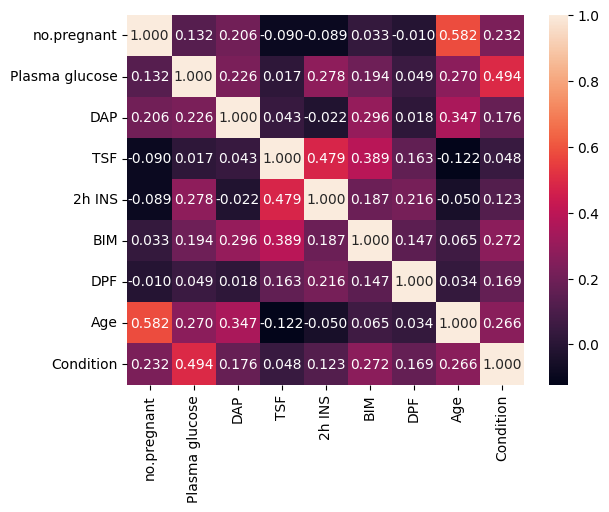

In [52]:
corr_matrix = df.corr(numeric_only=True)

sns.heatmap(corr_matrix, annot=True, fmt=".3f")

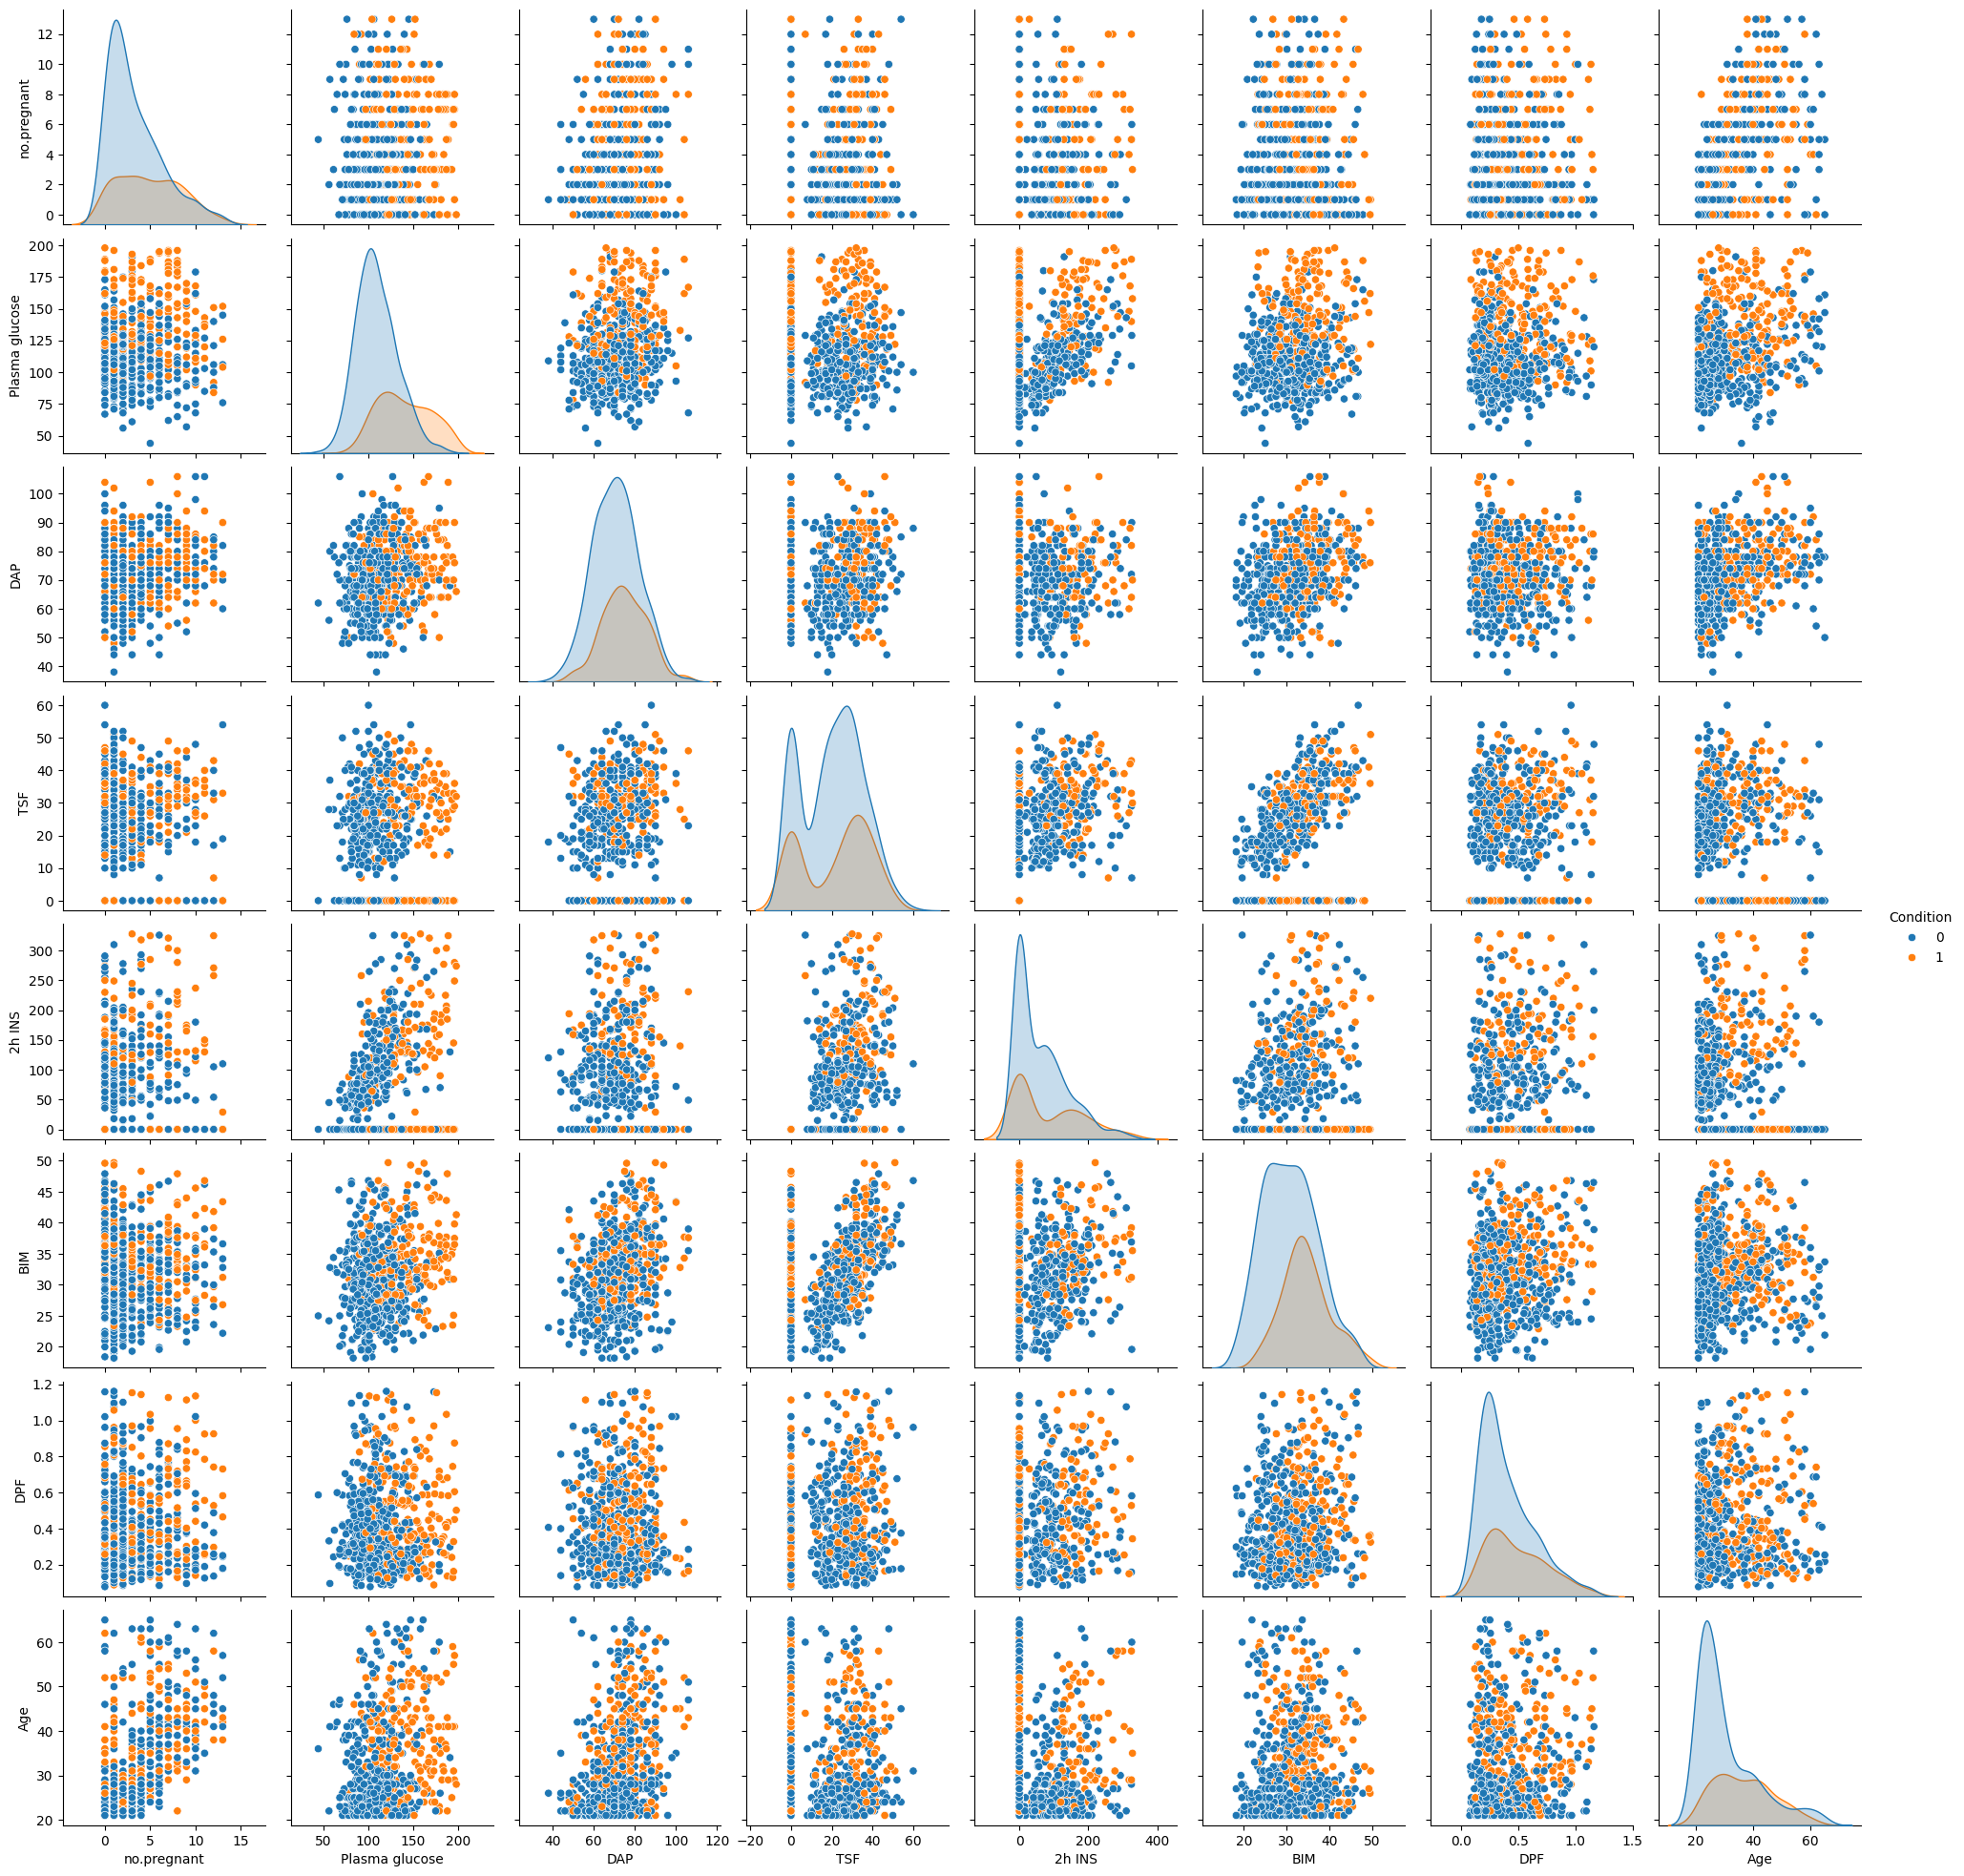

In [53]:
sns.pairplot(df, hue="Condition")

# Model Training
 

In [54]:
from sklearn.model_selection import train_test_split


from sklearn.linear_model import LogisticRegression


from sklearn.metrics import accuracy_score, classification_report


from sklearn.preprocessing import StandardScaler


X, Y = df[df.columns[:-1]], df[df.columns[-1]]
X = StandardScaler().fit_transform(X)
label_encoder = preprocessing.LabelEncoder()
Y = label_encoder.fit_transform(Y)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [56]:
model = LogisticRegression(max_iter=10000)

model.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [57]:
def calcModelScore(model, X_test, y_test):
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    print("Accuracy:", accuracy)
    print("Classification Report:\n", classification_report(y_test, predictions))

In [58]:
calcModelScore(model, X_test, y_test)

Accuracy: 0.8203125
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.93      0.88        88
           1       0.79      0.57      0.67        40

    accuracy                           0.82       128
   macro avg       0.81      0.75      0.77       128
weighted avg       0.82      0.82      0.81       128



# To improve model performance
1-Linear regression imputation to missing values <br>2-Over sample to balance traget classes

In [59]:
from sklearn.linear_model import LinearRegression
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV

# Linear regression imputation

In [60]:
imputationModel = LinearRegression()
oulayers_DataFrame = pd.DataFrame(df.columns.values)
imputed_df = pd.DataFrame(columns=df.columns)
minLimit, maxLimit = upperLowerLimit(df)
for i, col in enumerate(df.columns[:-2]):
    outliers = removed.loc[
        (removed[col] <= minLimit[col]) | (removed[col] >= maxLimit[col])
    ].reset_index(drop=True)
    if len(outliers):
        newDF = df.copy()

        Y_new = newDF[col]
        X_new = newDF.drop(col, axis=1)
        imputationModel.fit(X=X_new, y=Y_new)
        imputedOutlaier = imputationModel.predict(
            outliers.drop(col, axis=1, inplace=False)
        )
        Lastindex = len(df)

        for i in range(len(outliers)):
            outliers.at[i, col] = imputedOutlaier[i]
        Lastindex = len(df)
        imputed_df = pd.concat([imputed_df, outliers])

imputed_df = pd.concat([imputed_df, df])
X_imputed, Y_imputed = (
    imputed_df[imputed_df.columns[:-1]],
    imputed_df[imputed_df.columns[-1]],
)

C:\Users\Hossam\AppData\Local\Temp\ipykernel_31860\2491650501.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  imputed_df = pd.concat([imputed_df, outliers])


# Random over sampling

In [61]:
X_imputed = StandardScaler().fit_transform(X_imputed)
label_encoder = preprocessing.LabelEncoder()
Y_imputed = label_encoder.fit_transform(Y_imputed)
X_imputed_train, X_imputed_test, y_imputed_train, y_imputed_test = train_test_split(
    X_imputed, Y_imputed, test_size=0.2, random_state=1
)
ros = RandomOverSampler(random_state=1, sampling_strategy=0.8)
X_resampled, y_resampled = ros.fit_resample(X_imputed_train, y_imputed_train)

# Grid search

In [62]:
param_grid = {
    "C": np.arange(0.05, 1, 0.01),
    "penalty": ["l2"],
    "solver": ["liblinear", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"],
}

model = LogisticRegression(max_iter=1000)
grid_search = GridSearchCV(model, param_grid, cv=20)
grid_search.fit(X_resampled, y_resampled)
model2 = LogisticRegression(
    solver=grid_search.best_params_["solver"],
    C=grid_search.best_params_["C"],
    penalty=grid_search.best_params_["penalty"],
    max_iter=1000,
)
model2.fit(X_resampled, y_resampled)
calcModelScore(model2, X_imputed_test, y_imputed_test)

Accuracy: 0.8205128205128205
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.85      0.87       106
           1       0.70      0.76      0.73        50

    accuracy                           0.82       156
   macro avg       0.79      0.80      0.80       156
weighted avg       0.83      0.82      0.82       156



In [63]:
grid_search.best_params_

{'C': 0.07, 'penalty': 'l2', 'solver': 'liblinear'}